In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
mass = 0.05
mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

KeyboardInterrupt: 

In [ ]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1652886022778008e-16


In [ ]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=200,max_levels=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x8
  Level 1: 4x4x4x4
self.grid_list:[[8, 8, 8, 8], [4, 4, 4, 4]]
Norm of b:1.12115637175306
Norm of r:1.12115637175306
Norm of x0:0.0
BICGSTAB-Iteration 0: Residual = 1.929314e-01, Time = 0.044564 s
BICGSTAB-Iteration 1: Residual = 6.371150e-02, Time = 0.008402 s
BICGSTAB-Iteration 2: Residual = 1.329530e-01, Time = 0.006443 s
BICGSTAB-Iteration 3: Residual = 2.145065e-02, Time = 0.003532 s
BICGSTAB-Iteration 4: Residual = 1.614341e-02, Time = 0.003242 s
BICGSTAB-Iteration 5: Residual = 9.394413e-03, Time = 0.002769 s
BICGSTAB-Iteration 6: Residual = 6.988029e-03, Time = 0.002986 s
BICGSTAB-Iteration 7: Residual = 1.605667e-02, Time = 0.002805 s
BICGSTAB-Iteration 8: Residual = 6.915419e-03, Time = 0.004454 s
BICGSTAB-Iteration 9: Residual = 6.725968e-03, Time = 0.003864 s
BICGSTAB-Iteration 10: Residual = 3.368002e-03, Time = 0.002952 s
BICGSTAB-Iterat

In [ ]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [ ]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.26 ms, sys: 267 μs, total: 2.53 ms
Wall time: 2.3 ms
CPU times: user 2.46 ms, sys: 290 μs, total: 2.75 ms
Wall time: 2.39 ms
221.70250336881628
10.62561944948037
248.38478708613687
248.38478708613687
1.7505229586402284e-16
CPU times: user 19 ms, sys: 624 μs, total: 19.7 ms
Wall time: 18.8 ms


In [ ]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 4.62 ms, sys: 0 ns, total: 4.62 ms
Wall time: 3.77 ms
CPU times: user 3.51 ms, sys: 0 ns, total: 3.51 ms
Wall time: 3.44 ms


In [ ]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [ ]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:221.3797633073902
Norm of r:332.7442554165274
Norm of x0:221.41449339488415
BICGSTAB-Iteration 0: Residual = 7.183947e+01, Time = 0.003025 s
BICGSTAB-Iteration 1: Residual = 3.026986e+01, Time = 0.006408 s
BICGSTAB-Iteration 2: Residual = 3.052723e+01, Time = 0.006503 s
BICGSTAB-Iteration 3: Residual = 2.063003e+01, Time = 0.003566 s
BICGSTAB-Iteration 4: Residual = 1.273302e+01, Time = 0.003317 s
BICGSTAB-Iteration 5: Residual = 9.926033e+00, Time = 0.003330 s
BICGSTAB-Iteration 6: Residual = 7.738278e+00, Time = 0.003404 s
BICGSTAB-Iteration 7: Residual = 1.900798e+01, Time = 0.003278 s
BICGSTAB-Iteration 8: Residual = 4.382611e+00, Time = 0.003111 s
BICGSTAB-Iteration 9: Residual = 5.613314e+00, Time = 0.002812 s
BICGSTAB-Iteration 10: Residual = 5.389500e+00, Time = 0.002859 s
BICGSTAB-Iteration 11: Residual = 4.895596e+00, Time = 0.002936 s
BICGSTAB-Iteration 12: Residual = 3.927878e+01, Time = 0.003363 s
BICGSTAB-Iteration 13: Residual = 1.186566e+01, Time = 0.002904 s


Norm of b:221.3797633073902
Norm of r:334.37554553826436
Norm of x0:222.05283536782224
restrict:shape,coarse_dof:(torch.Size([12, 12, 4, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
Norm of b:31.421349535746064
Norm of r:31.421349535746064
Norm of x0:0.0
MG-1-BICGSTAB-Iteration 0: Residual = 4.364873e+01, Time = 0.002192 s
MG-1-BICGSTAB-Iteration 1: Residual = 7.937329e+01, Time = 0.002282 s
MG-1-BICGSTAB-Iteration 2: Residual = 2.794613e+01, Time = 0.002718 s
MG-1-BICGSTAB-Iteration 3: Residual = 2.427994e+02, Time = 0.002774 s
MG-1-BICGSTAB-Iteration 4: Residual = 2.335578e+01, Time = 0.002949 s
MG-1-BICGSTAB-Iteration 5: Residual = 1.573169e+02, Time = 0.002699 s
MG-1-BICGSTAB-Iteration 6: Residual = 2.322428e+01, Time = 0.002674 s
MG-1-BICGSTAB-Iteration 7: Residual = 1.048815e+02, Time = 0.002827 s
MG-1-BICGSTAB-Iteration 8: Residual = 1.676517e+01, Time = 0.005129 s
MG-1-BICGSTAB-Iteration 9: Residual = 2.351675e+01, Time = 0.005233 s
MG-1-BICGSTAB-Iteration 10: Residua

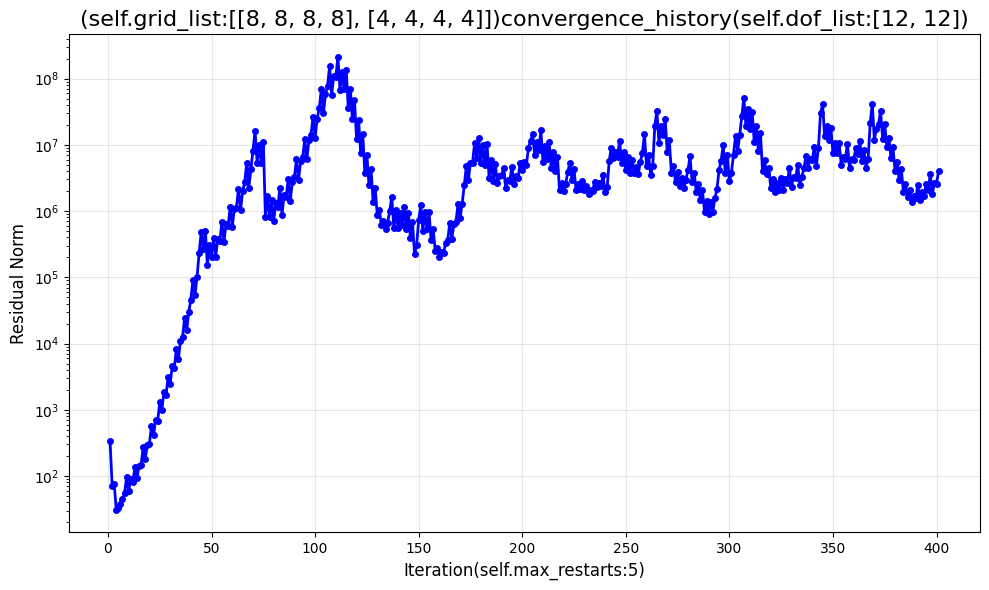

In [ ]:
x = mg.solve()
mg.plot()

In [ ]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([  6860.5003-2.8199e+04j,   5511.0851-2.1301e+04j,
          8211.7003+9.5876e+03j,   7639.0840+1.1725e+04j,
         -1879.4077+8.4273e+03j,  -4982.1968+8.9934e+03j,
         -1169.7691-2.5077e+03j,  -2491.7239-3.8558e+03j,
          1239.0255-2.6332e+04j,   3765.6681-2.7306e+04j,
         12155.1975+9.8540e+03j,  10075.6168+1.0125e+04j,
         -4460.1350+1.0290e+04j,  -7873.9318+1.0153e+04j,
          -622.2630+7.8877e+03j,  -3391.0596-1.7432e+03j,
        -14352.6978-9.8799e+03j, -12830.3932-7.4453e+03j,
          8282.0394-1.5196e+04j,   9413.1371-9.2239e+03j,
         -2017.9739-1.7694e+03j,  -3019.2112+5.8176e+02j,
         17842.7909+1.8381e+04j,  18918.5106+1.9178e+04j,
        -20426.8137-1.9736e+03j, -17010.9532-3.9614e+03j,
         -2342.9997-7.5260e+03j,  -1144.7582-6.7342e+03j,
         -4142.5818-6.1613e+03j,  -3780.6914-1.0330e+03j,
         26729.3848+2.2894e+04j,  17586.0686+2.3472e+04j,
         -7500.2758+4.0069e+04j, -12859.2544+3.3297e+04j,
         -8469

In [ ]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

15039.407327808283


In [ ]:
mg.num_levels

2

In [ ]:
index = -1
mg.u_list[-1] = inverse.bicgstab(b=torch.ones_like(mg.b_list[-1]),
                                 matvec=mg.op_list[-1].matvec, verbose=verbose,max_iter=10000)

Norm of b:55.42562584220407
Norm of r:135.89949205995916
Norm of x0:55.594670663712115
BICGSTAB-Iteration 0: Residual = 1.625896e+02, Time = 0.007081 s
BICGSTAB-Iteration 1: Residual = 1.381824e+02, Time = 0.003809 s
BICGSTAB-Iteration 2: Residual = 8.641553e+01, Time = 0.003007 s
BICGSTAB-Iteration 3: Residual = 8.248595e+01, Time = 0.002848 s
BICGSTAB-Iteration 4: Residual = 3.388115e+01, Time = 0.003502 s
BICGSTAB-Iteration 5: Residual = 4.568335e+01, Time = 0.002667 s
BICGSTAB-Iteration 6: Residual = 5.597635e+01, Time = 0.002299 s
BICGSTAB-Iteration 7: Residual = 2.268239e+01, Time = 0.002126 s
BICGSTAB-Iteration 8: Residual = 1.139978e+02, Time = 0.001967 s
BICGSTAB-Iteration 9: Residual = 2.067430e+01, Time = 0.002290 s
BICGSTAB-Iteration 10: Residual = 2.498231e+02, Time = 0.002030 s
BICGSTAB-Iteration 11: Residual = 2.035408e+01, Time = 0.001822 s
BICGSTAB-Iteration 12: Residual = 5.115861e+01, Time = 0.002123 s
BICGSTAB-Iteration 13: Residual = 9.883261e+01, Time = 0.002738 s